In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import astropy.io.fits as pyfits
import astropy.wcs as wcs

import os

In [2]:
## import functions
import GMM_plot_library as pGMM
import GMM_functions as fGMM
import velocity_axis_datacube as vax

In [3]:
## input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'
unit_integrated_intensity = '$\int$T$_{mb}$dv (K km s$^{-1}$)'

## get information on the wings
name_file_blue = 'RCW79_CII_final_20_8_0p5_clean_blue.fits'
name_file_red = 'RCW79_CII_final_20_8_0p5_clean_red.fits'

## input for the Gaussian Mixture Models
n_comps_min = 1
n_comps_max = 12

## information for the observational information
min_vels = [-70., -42.] ## km/s
max_vels= [-52., -25.] ## km/s
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"
rms_cutoff = 5. 

In [4]:
## get the data and header information
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information (in km/s)
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']
print(dv)

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)
print(w)

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   
0.5
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SFL'  'DEC--SFL'  
CRVAL : 205.02442  -61.710261  
CRPIX : 97.82400030166  92.32306353733  
NAXIS : 188  188


In [5]:
## open the integrated intensity maps associated with the blue and red wings
hdu = pyfits.open(path_file + name_file_blue)
hdu.info()
data_blue = hdu[0].data

hdu = pyfits.open(path_file + name_file_red)
hdu.info()
data_red = hdu[0].data

Filename: data/RCW79_CII_final_20_8_0p5_clean_blue.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (188, 188)   float32   
Filename: data/RCW79_CII_final_20_8_0p5_clean_red.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (188, 188)   float32   


In [6]:
## combine the intensity maps of the blue and red wings
data_wings = data_blue + data_red
print(data_wings.shape)

(188, 188)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SFL'  'DEC--SFL'  
CRVAL : 205.02442  -61.710261  
CRPIX : 97.82400030166  92.32306353733  
NAXIS : 188  188


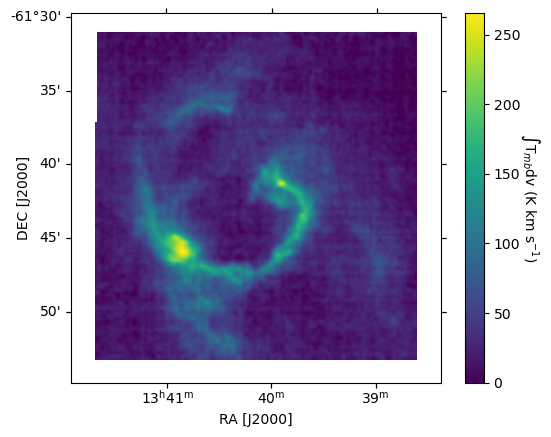

In [7]:
pGMM.inspect_intensity_map(data, dv, w, unit_integrated_intensity, cmap_col = 'viridis')

In [8]:
## reduce the data size along the z-axis to the region associated with emission
data_red_list = []
for min_vel, max_vel in zip(min_vels, max_vels):
    data_red_list.append(vax.reduce_z_axis_size(data, min_vel, max_vel, crval, dv, crpix))

## concatenate the data
data_reduced = np.concatenate(data_red_list, axis = 0)

The minimal pixel along the z-axis is: 40
The maximal pixel along the z-axis is: 76
The minimal pixel along the z-axis is: 96
The maximal pixel along the z-axis is: 130


In [9]:
## cut data where there are no detected wings
for y in range(0, data_wings.shape[0]):
    for x in range(0, data_wings.shape[1]):
        if(data_wings[y][x] < rms_cutoff):
            data_reduced[:, y, x] = np.nan

In [10]:
## prepare the data before the GMM loop
index_array, data_input = fGMM.prepare_data(data_reduced)

## fit the GMM
(n_comp_list_orig, bic_list_orig, time_list_orig, best_model_orig, norm_lower_bound_list_orig) = fGMM.fit_GMM(data_input, n_comps_min, n_comps_max, print_time = True)

Dimensions of resampled data: (70, 35344)
Calculating GMM for 1 components
total time: 0.0773630142211914 s
converged: True
num iterations: 2


Calculating GMM for 2 components


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:31: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


total time: 0.44615912437438965 s
converged: True
num iterations: 14


Calculating GMM for 3 components
total time: 1.0355792045593262 s
converged: True
num iterations: 23


Calculating GMM for 4 components
total time: 5.444892883300781 s
converged: True
num iterations: 81


Calculating GMM for 5 components
total time: 4.068339824676514 s
converged: True
num iterations: 58


Calculating GMM for 6 components
total time: 8.148054122924805 s
converged: True
num iterations: 96


Calculating GMM for 7 components
total time: 4.428605318069458 s
converged: True
num iterations: 37


Calculating GMM for 8 components
total time: 9.56872296333313 s
converged: True
num iterations: 84


Calculating GMM for 9 components
total time: 10.201155662536621 s
converged: True
num iterations: 73


Calculating GMM for 10 components
total time: 13.39100432395935 s
converged: True
num iterations: 80


Calculating GMM for 11 components
total time: 21.567227840423584 s
converged: True
num iterations: 119




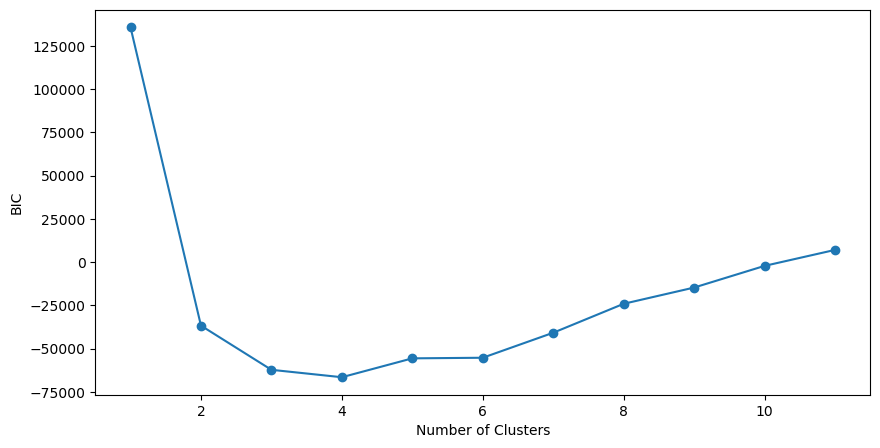

In [11]:
## plot BIC result as a function of the number of components
pGMM.plot_two_lists(n_comp_list_orig, bic_list_orig, "Number of Clusters", "BIC")

The minimal pixel along the z-axis is: 40
The maximal pixel along the z-axis is: 130
The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3


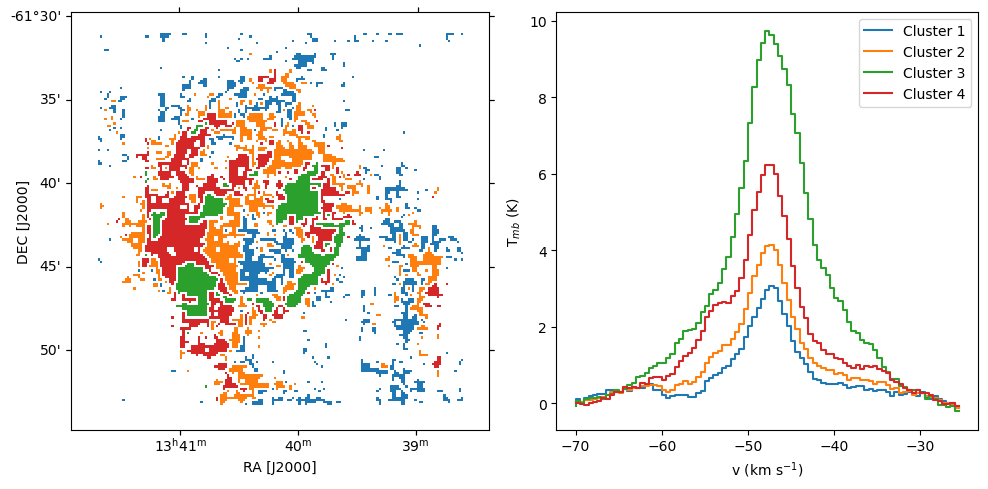

In [12]:
## Obtain the indices for the different clusters
cluster_inds = best_model_orig.predict(data_input)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity and resampled velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_vels[0], max_vels[1], dv)

## prepare data to plot
data_plot = vax.reduce_z_axis_size(data, min_vels[0], max_vels[1], crval, dv, crpix)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_plot, cluster_map, vel_arr, w, plot_path = 'plots/test.pdf')